In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import transformers
from transformers import CamembertTokenizer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

In [6]:
df = pd.read_csv("hf://datasets/readerbench/fakenews-climate-fr/fake-fr.csv")
df.to_csv("climate.csv")
df.head()

,Text,Label
0,\nUne réflexion collective qui est aussi quoi ...,fake
1,\nDès l’élaboration de la Convention-cadre des...,true
2,"\n""On peut parler d'invasion, d'invasion génér...",true
3,"\nLa Rochelle, le 14 mars 2008. Un navire en p...",biased
4,\nJ’ai eu le plaisir de visiter le Japon il n’...,fake


In [7]:
from datasets import Dataset
# Encodage des labels (fake, true, biased → 0,1,2)
label_encoder = LabelEncoder()
df["Label"] = label_encoder.fit_transform(df["Label"])

# train/test split stratifié
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["Label"]
)

# Conversion HuggingFace dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [8]:
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

def tokenize(batch):
    return tokenizer(
        batch["Text"],
        truncation=True,
        padding="max_length",
        max_length=256
    )

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/1947 [00:00<?, ? examples/s]

Map:   0%|          | 0/487 [00:00<?, ? examples/s]

In [9]:
# Fix columns format for HF Trainer
train_dataset = train_dataset.rename_column("Label", "labels")
test_dataset = test_dataset.rename_column("Label", "labels")
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

In [10]:
from transformers import CamembertForSequenceClassification
# 3. Charger le modèle CamemBERT
model = CamembertForSequenceClassification.from_pretrained(
    "camembert-base",
    num_labels=len(label_encoder.classes_)   # 3 classes
)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# 4. Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }

In [23]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    save_steps=500,
    eval_steps=500,
    logging_dir="./logs",
)

In [24]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# 6. Entraînement du modèle
trainer.train()

C:\Users\DAGHY\AppData\Local\Temp\ipykernel_11784\1436694088.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\DAGHY\anaconda3\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)
c:\Users\DAGHY\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,0.548500


TrainOutput(global_step=732, training_loss=0.47110705558068117, metrics={'train_runtime': 7718.5754, 'train_samples_per_second': 0.757, 'train_steps_per_second': 0.095, 'total_flos': 768422736474624.0, 'train_loss': 0.47110705558068117, 'epoch': 3.0})

In [46]:
import torch
from transformers import CamembertForSequenceClassification, CamembertTokenizer
from sklearn.preprocessing import LabelEncoder

# === 0️⃣ Préparation label_encoder ===
label_encoder = LabelEncoder()
label_encoder.fit(['biased', 'fake', 'true'])  # tes labels finaux

# === 1️⃣ Chemin vers le checkpoint ===
checkpoint_path = "./results/checkpoint-732"

# === 2️⃣ Charger modèle et tokenizer ===
model = CamembertForSequenceClassification.from_pretrained(checkpoint_path)
tokenizer = CamembertTokenizer.from_pretrained(checkpoint_path)
model.eval()

# === 3️⃣ Texte(s) à prédire ===
texts = ["La pollution n'affecte pas le climat, elle ne touche que la santé humaine."]

# === 4️⃣ Tokenisation ===
inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True)

# === 5️⃣ Prédiction ===
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    probs = torch.softmax(logits, dim=1)

# === 6️⃣ Récupérer labels internes ===
pred_ids = torch.argmax(probs, dim=1).tolist()
pred_labels_internal = [model.config.id2label[i] for i in pred_ids]

# === 7️⃣ Mapping vers labels finaux ===
internal_to_final = {
    "LABEL_0": "biased",
    "LABEL_1": "fake",
    "LABEL_2": "true"
}
pred_labels_final = [internal_to_final[label] for label in pred_labels_internal]

# === 8️⃣ Affichage clair des probabilités ===
for text, label, prob_tensor in zip(texts, pred_labels_final, probs):
    print("🔮 Texte :", text)
    print("📌 Classe prédite :", label)
    prob_list = prob_tensor.tolist()
    # Associer chaque probabilité au label final correspondant
    prob_dict = {internal_to_final[model.config.id2label[i]]: prob_list[i] 
                 for i in range(len(prob_list))}
    print("📊 Probabilités par classe :", prob_dict)
    print("---")


🔮 Texte : La pollution n'affecte pas le climat, elle ne touche que la santé humaine.
📌 Classe prédite : true
📊 Probabilités par classe : {'biased': 0.010014768689870834, 'fake': 0.016945529729127884, 'true': 0.9730396866798401}
---


In [34]:
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(axis=1)
y_true = predictions.label_ids


c:\Users\DAGHY\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


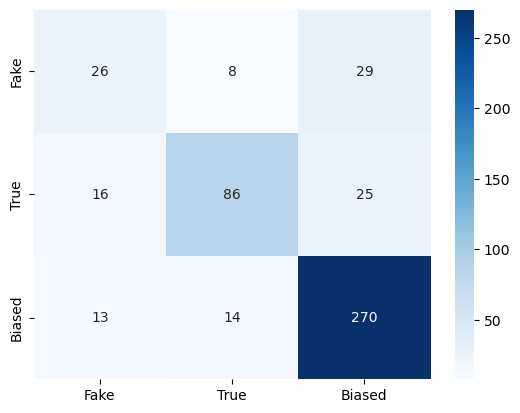

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["Fake", "True", "Biased"]
cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))

sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=labels,
            yticklabels=labels)
plt.show()
